In [1]:
import pandas as pd
import numpy as np
import random

file_path = 'Shopee-Product-20oz-September-2023.xlsx'


data = pd.read_excel(file_path, header=None)
num_products = 25
rows_per_product = 30

product_dfs = []

# Loop through the rows in steps of (rows_per_product + 2 para ma skip yung titles and headers per product )
for i in range(0, len(data), rows_per_product + 2):
    # To DataFrame
    product_data = data.iloc[i + 2:i + rows_per_product + 2]
    product_data.columns = ["day", "product_sold", "price", "rating", "total_rating", "status"]
    product_df = product_data.copy()

    product_dfs.append(product_df)

print('DataFrames:')
for idx, product_df in enumerate(product_dfs):
    print(f'Product {idx + 1}:')
    print(product_df)

DataFrames:
Product 1:
   day product_sold price rating total_rating     status
2    1         1000   500      5          449  Available
3    2         1000  2490      5          450  Available
4    3         1000  2490      5          450  Available
5    4         1000  2490      5          450  Available
6    5         1000  2490      5          450  Available
7    6         1000  2490      5          450  Available
8    7         1000  2490      5          451  Available
9    8         1000  2490      5          451  Available
10   9         1000  1590      5          451  Available
11  10         1000  1590      5          452  Available
12  11         1000  1590      5          452  Available
13  12         1000  1590      5          454  Available
14  13         1000  1590      5          456  Available
15  14         1000  2490      5          456  Available
16  15         1000  2490      5          456  Available
17  16         1100  2490      5          463  Available
18  17  

In [2]:
product_df = pd.concat(product_dfs, ignore_index=True)
product_df['product_id'] = np.repeat(range(1, num_products + 1), rows_per_product)


class PricingEnvironment:
    def __init__(self, data):
        self.data = data
        self.num_products = len(data['product_id'].unique())  # Number of unique product IDs
        self.current_day = 0
        self.current_product = None
        self.done = False
        self.prices = []
        self.state = {}
        
        
    def _get_state(self):
        return self.data[self.data['product_id'] == self.current_product]

    def reset(self, product_id=None):
        self.current_day = 0
        self.done = False
        self.current_product = product_id or random.randint(1, self.num_products)
        self.prices = list(self._get_state()['price']) 
        
        # Convert 'product_sold' column to a list when constructing self.state
        self.state = {
            'product_sold': list(self._get_state()['product_sold']),
            'price': list(self._get_state()['price']),
            'rating': list(self._get_state()['rating']),
            'total_rating': list(self._get_state()['total_rating']),
            'status': list(self._get_state()['status'])
        }
        
        return self.state



    def step(self, actions):
        # Next state
        if self.done:
            raise ValueError("Episode is done, call reset() to start a new episode.")

        # Update prices 
        self.prices = actions

        #Next day
        self.current_day += 1

        # If 30 days for the current product are processed, move to the next product
        if self.current_day % 30 == 0:
            self.current_product += 1
            if self.current_product > self.num_products:
                self.done = True
                return None, 0, True, {}
            self.prices = list(self._get_state()['price'])  # Reset prices for the new product
        
        # Get the next state (products' data for the next day)
        self.state = self._get_state()
        
        # Ensure that both product_sold and prices are lists before using zip
        product_sold_list = list(self.state['product_sold'])
        prices_list = list(self.prices)
        revenue = sum(product_sold * price for product_sold, price in zip(product_sold_list, prices_list))

        return self.state, revenue, self.done, {}

    def get_observation_space(self):
        return len(self.state)

    def get_action_space(self):
        return self.num_products

# Calls
env = PricingEnvironment(product_df)
initial_state = env.reset()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random


class DQNAgent(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQNAgent, self).__init__()
        self.fc = nn.Linear(input_size, 128)  # Outputmatch the input size of the next layer
        self.out = nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        return self.out(x)


class DQNAgentWrapper:
    def __init__(self, input_size, output_size, epsilon=0.1, lr=0.001, gamma=0.99):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epsilon = epsilon
        self.gamma = gamma
        self.model = DQNAgent(input_size, output_size).to(self.device)
        self.target_model = DQNAgent(input_size, output_size).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.steps = 0 

    def preprocess_state(self, state):
        # Convert string values to numerical format and return the processed state
        processed_state = {
        'product_sold': [float(value) for value in state['product_sold']],  # Convert all elements to float
        'price': [float(value) for value in state['price']],  
        'rating': [float(value) for value in state['rating']], 
        'total_rating': [float(value) for value in state['total_rating']],  
        'status': [1.0 if status == 'Available' else 0.0 for status in state['status']]
        
    }
        return processed_state 
        

    def choose_prices(self, state):
        processed_state = self.preprocess_state(state)

        state_values = [float(value) for values_list in processed_state.values() for value in values_list]

        with torch.no_grad():
            state_tensor = torch.tensor(state_values, dtype=torch.float32).to(self.device)
            state_tensor = state_tensor.unsqueeze(0)  
            q_values = self.model(state_tensor)
            
            top_prices_indices = torch.argsort(q_values, descending=True).flatten()[:self.get_action_space()]
            chosen_prices = [float(top_price) for top_price in top_prices_indices]
            
            return chosen_prices

    def train(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(self.device)
        action = torch.tensor(action, dtype=torch.int64).to(self.device)
        reward = torch.tensor(reward, dtype=torch.float32).to(self.device)
        done = torch.tensor(done, dtype=torch.float32).to(self.device)

        q_values = self.model(state)
        next_q_values = self.target_model(next_state)

        q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_value = reward + (1 - done) * self.gamma * next_q_values.max(dim=1)[0]

        loss = nn.MSELoss()(q_value, next_q_value.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps % 1000 == 0:
            self.update_target_model()

            self.steps += 1

    def get_action_space(self):
        return self.model.out.out_features
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())



Day 1: [955.0, 1084.0, 1411.0, 234.0, 1538.0, 1187.0, 360.0, 309.0, 905.0, 876.0, 1534.0, 1527.0, 1332.0, 882.0, 1824.0, 1124.0, 1704.0, 311.0, 1807.0, 1297.0, 364.0, 378.0, 56.0, 1994.0, 214.0, 730.0, 1561.0, 1489.0, 1835.0, 788.0, 1315.0, 430.0, 7.0, 62.0, 137.0, 268.0, 259.0, 1477.0, 1752.0, 1391.0, 1531.0, 1227.0, 1900.0, 1383.0, 482.0, 1905.0, 886.0, 1247.0, 867.0, 1800.0, 648.0, 1585.0, 383.0, 942.0, 1571.0, 1057.0, 260.0, 668.0, 1497.0, 2.0, 1703.0, 1578.0, 1468.0, 786.0, 1594.0, 503.0, 1588.0, 349.0, 1633.0, 114.0, 1677.0, 1555.0, 1746.0, 1427.0, 1209.0, 1094.0, 605.0, 245.0, 1871.0, 1090.0, 1077.0, 1486.0, 425.0, 1069.0, 1914.0, 428.0, 1134.0, 972.0, 766.0, 1197.0, 1155.0, 1119.0, 1697.0, 1319.0, 612.0, 1320.0, 170.0, 711.0, 582.0, 1735.0, 1904.0, 275.0, 657.0, 1430.0, 1745.0, 1844.0, 1867.0, 1305.0, 1789.0, 1707.0, 1070.0, 1719.0, 1545.0, 1658.0, 667.0, 61.0, 676.0, 1419.0, 474.0, 0.0, 436.0, 366.0, 1792.0, 495.0, 735.0, 1537.0, 1665.0, 674.0, 738.0, 1597.0, 164.0, 1148.0, 85

Day 5: [955.0, 1411.0, 1084.0, 234.0, 1538.0, 309.0, 360.0, 1187.0, 905.0, 1124.0, 1527.0, 1534.0, 364.0, 876.0, 1824.0, 1704.0, 311.0, 1297.0, 1807.0, 730.0, 1247.0, 1561.0, 62.0, 214.0, 378.0, 886.0, 882.0, 56.0, 1332.0, 1391.0, 1489.0, 1835.0, 7.0, 1315.0, 259.0, 1994.0, 137.0, 1752.0, 268.0, 1227.0, 1383.0, 482.0, 1531.0, 1905.0, 788.0, 867.0, 1703.0, 1900.0, 1571.0, 430.0, 260.0, 612.0, 1585.0, 942.0, 1477.0, 383.0, 1094.0, 1588.0, 1800.0, 425.0, 1578.0, 668.0, 1871.0, 972.0, 1594.0, 648.0, 786.0, 605.0, 2.0, 1468.0, 1677.0, 503.0, 1914.0, 245.0, 1633.0, 1090.0, 766.0, 1209.0, 1077.0, 1057.0, 349.0, 1735.0, 1904.0, 1305.0, 114.0, 1486.0, 735.0, 1746.0, 1697.0, 1707.0, 1069.0, 1197.0, 1155.0, 1427.0, 711.0, 1497.0, 1537.0, 1745.0, 1658.0, 1070.0, 436.0, 1430.0, 275.0, 428.0, 164.0, 1320.0, 1867.0, 1376.0, 667.0, 366.0, 170.0, 738.0, 1319.0, 1134.0, 657.0, 1555.0, 237.0, 1597.0, 1665.0, 852.0, 61.0, 1719.0, 582.0, 841.0, 1545.0, 998.0, 373.0, 156.0, 1401.0, 985.0, 719.0, 676.0, 1148

ValueError: x and y must have same first dimension, but have shapes (30,) and (0,)

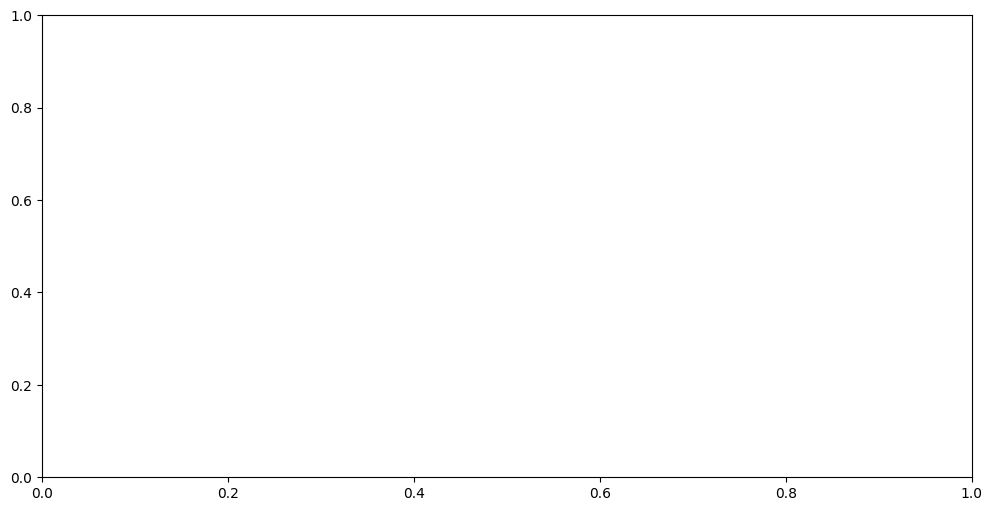

In [4]:
env = PricingEnvironment(product_df)
input_size = 150  
output_size = 2000  
agent = DQNAgentWrapper(input_size, output_size) 

# Lists to store prices and revenues for each day
prices_history = []
revenues_history = []
daily_revenues = []

for day in range(1, 31):
    # Get the current state from the environment
    product_id = random.randint(1, num_products)  # Choose a random product ID
    state = env.reset(product_id)

    # Choose prices using the RL agent
    prices = agent.choose_prices(state)

    # Step through the environment with the chosen prices
    _, revenue, _, _ = env.step(prices)

    # Store the total revenue for the day
    daily_revenues.append(revenue)

    # Print the day number and the calculated price for that day
    print(f"Day {day}: {prices}")

    # Store the prices for plotting
    prices_history.append(prices)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(1, 31), revenues_history, marker='o', color='b', label='Daily Revenue')
plt.xlabel('Day')
plt.ylabel('Reward')
plt.title('Daily Revenue for 30 Days (Considering 25 Products Each Day)')
plt.legend()
plt.grid(True)
plt.show()